In [1]:
from __future__ import division, print_function
import math, random
from collections import defaultdict, Counter
from scipy import spatial
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# План занятия:
- обзор задач рекомендательных систем
- эвристические подходы к рекомендациям 
- item-based и user-based подходы
- методы оценивания рекомендательных систем
- библиотека surprise
- факторизационные машины
- домашнее задание к занятию по рекомендательным системам

# Рекомендательные системы

Заинтересованность компаний в разработке рекомендательных систем:

* покупка некоторого товара
* потребление некоторого контента и удержание пользователя

Покупка товара:

* Amazon
* Ozon
* Lamoda
* ...
* Ваши варианты?

### Lamoda
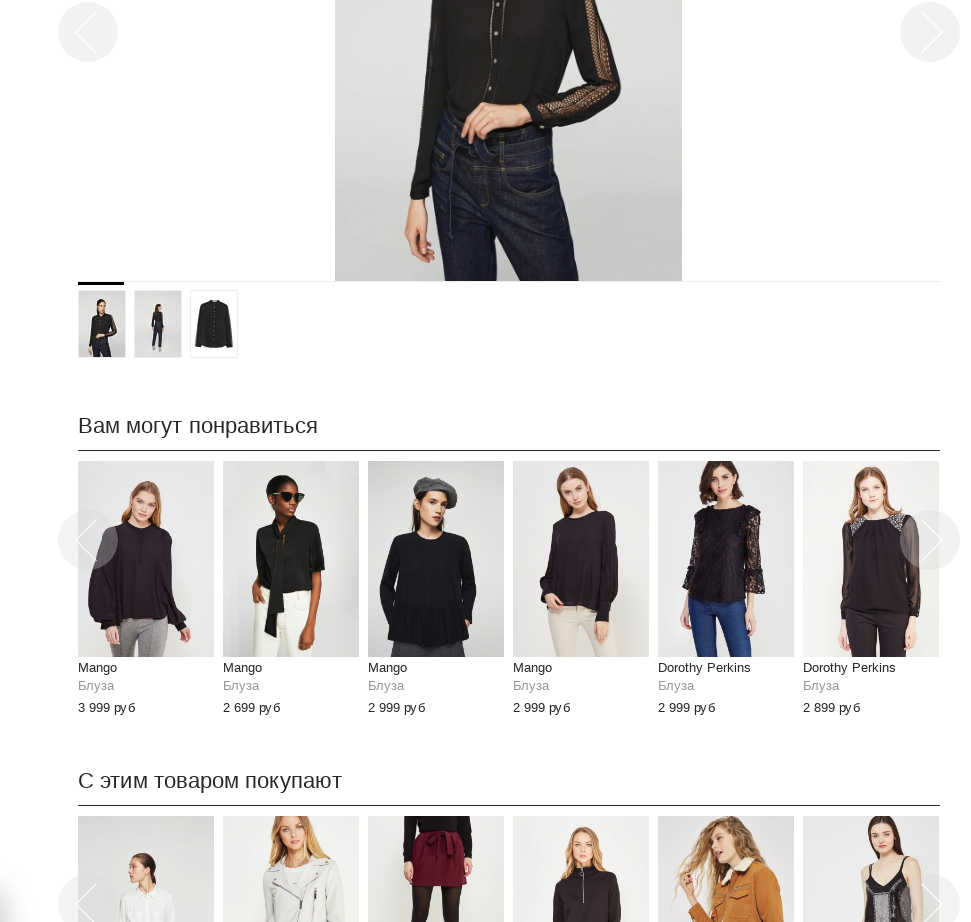

### Amazon
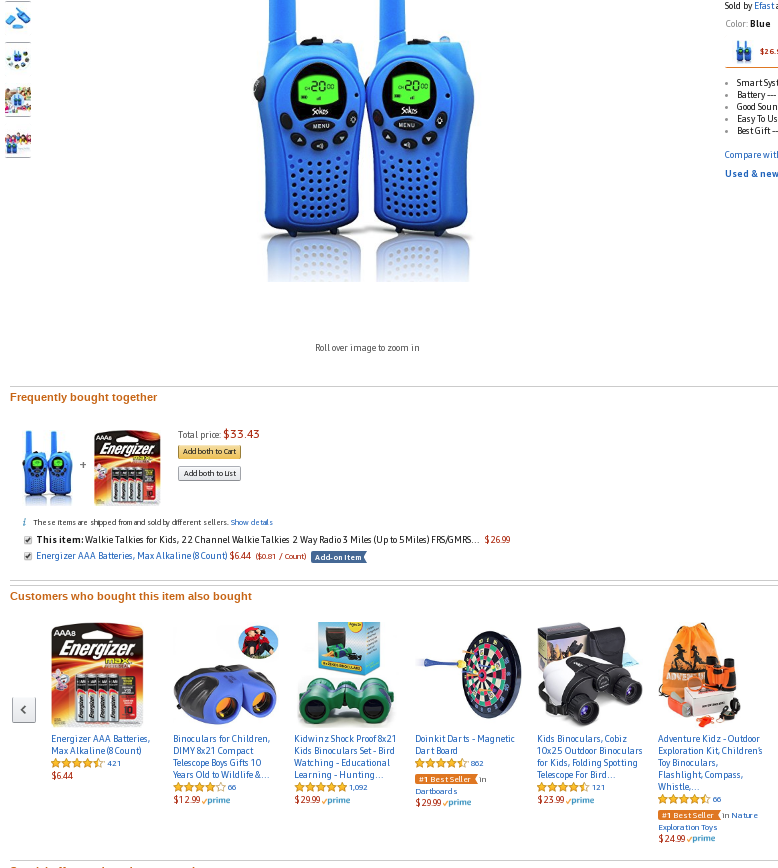

Удержание пользователя:
* Spotify
* Netflix
* LinkedIn
* Facebook

### LinkedIn

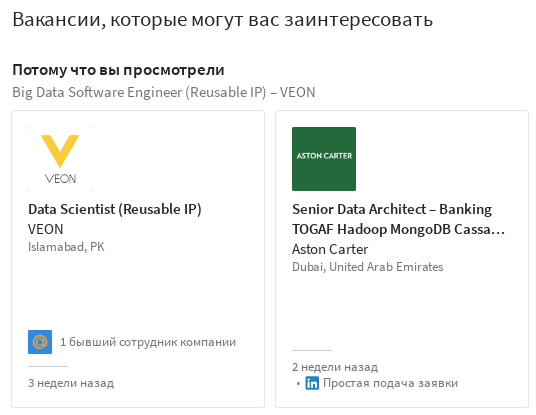

### LastFM

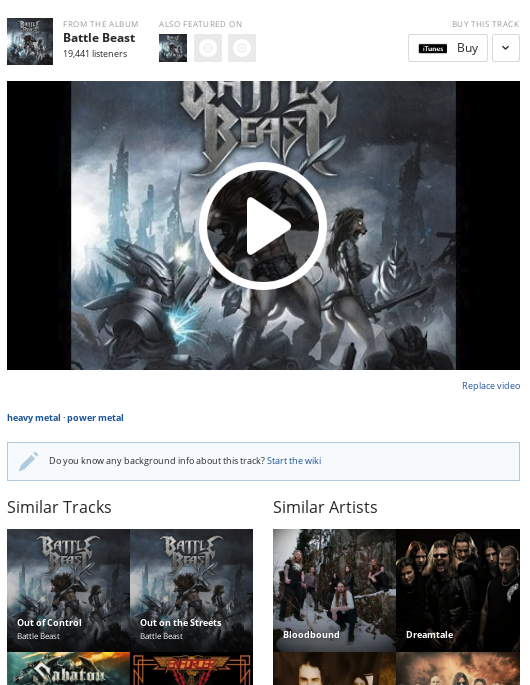

http://fortune.com/2012/07/30/amazons-recommendation-secret/

Уровни работы рекомендательных систем

* Долгосрочные интересы - медленно меняющиеся предпочтения
* Краткосрочные интересы - некоторые кратковременные тренды

Будем рассматривать модели для построения долгосрочных рекомендаций

### Упражнения:
предположим, вы строите рекомендательную систему для блога по машинному обучению.
Как решить эту задачу?

Рассмотрим пример из книги Data Science from scratch

https://github.com/joelgrus/data-science-from-scratch/

In [1]:
# темы повторяются у разных пользователей

users_interests = [
    ["Hadoop", "Big Data", "HBase", "Java", "Spark", "Storm", "Cassandra"],
    ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"],
    ["Python", "scikit-learn", "scipy", "numpy", "statsmodels", "pandas"],
    ["R", "Python", "statistics", "regression", "probability"],
    ["machine learning", "regression", "decision trees", "libsvm"],
    ["Python", "R", "Java", "C++", "Haskell", "programming languages"],
    ["statistics", "probability", "mathematics", "theory"],
    ["machine learning", "scikit-learn", "Mahout", "neural networks"],
    ["neural networks", "deep learning", "Big Data", "artificial intelligence"],
    ["Hadoop", "Java", "MapReduce", "Big Data"],
    ["statistics", "R", "statsmodels"],
    ["C++", "deep learning", "artificial intelligence", "probability"],
    ["pandas", "R", "Python"],
    ["databases", "HBase", "Postgres", "MySQL", "MongoDB"],
    ["libsvm", "regression", "support vector machines"]
]

unique_interests = sorted({interest for user_interests in users_interests for interest in user_interests})

print(unique_interests)
print(len(unique_interests))
print(len(users_interests))

['Big Data', 'C++', 'Cassandra', 'HBase', 'Hadoop', 'Haskell', 'Java', 'Mahout', 'MapReduce', 'MongoDB', 'MySQL', 'NoSQL', 'Postgres', 'Python', 'R', 'Spark', 'Storm', 'artificial intelligence', 'databases', 'decision trees', 'deep learning', 'libsvm', 'machine learning', 'mathematics', 'neural networks', 'numpy', 'pandas', 'probability', 'programming languages', 'regression', 'scikit-learn', 'scipy', 'statistics', 'statsmodels', 'support vector machines', 'theory']
36
15


Если пользователей и тем мало, то справится эксперт, и систему разрабатывать не нужно.  
Когда количество пользователей и тем/товаров исчисляется миллионами, давать рекомендацию нужно автоматически.

## Популярность темы

Простой подход - рекомендуем пользователю самые популярные темы

In [3]:
popular_interests = Counter(
    interest for user_interests in users_interests for interest in user_interests
).most_common()

print("Popular Interests")
print(popular_interests)

Popular Interests
[('Python', 4), ('R', 4), ('Java', 3), ('regression', 3), ('statistics', 3), ('probability', 3), ('HBase', 3), ('Big Data', 3), ('neural networks', 2), ('Hadoop', 2), ('deep learning', 2), ('pandas', 2), ('artificial intelligence', 2), ('libsvm', 2), ('C++', 2), ('Postgres', 2), ('MongoDB', 2), ('scikit-learn', 2), ('machine learning', 2), ('statsmodels', 2), ('Cassandra', 2), ('NoSQL', 1), ('Mahout', 1), ('Storm', 1), ('MySQL', 1), ('programming languages', 1), ('Haskell', 1), ('mathematics', 1), ('Spark', 1), ('numpy', 1), ('theory', 1), ('decision trees', 1), ('MapReduce', 1), ('scipy', 1), ('databases', 1), ('support vector machines', 1)]


In [4]:
def most_popular_new_interests(user_interests, max_results=5):
    suggestions = [(interest, frequency) 
                   for interest, frequency in popular_interests
                   if interest not in user_interests]
    return suggestions[:max_results]


print("Most Popular New Interests")
print("already like:", ["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"])
print(most_popular_new_interests(["NoSQL", "MongoDB", "Cassandra", "HBase", "Postgres"]))

Most Popular New Interests
already like: ['NoSQL', 'MongoDB', 'Cassandra', 'HBase', 'Postgres']
[('Python', 4), ('R', 4), ('Java', 3), ('regression', 3), ('statistics', 3)]


Такой подход применим для пользователей, о которых ничего не известно. Так называемый "холодный старт".
Почему он плохо работает для всех?

In [3]:
# составим матрицу интересов пользователей

v = DictVectorizer(sparse=False)

d = [{item: 1 for item in ui} for ui in users_interests]
user_interest_matrix = v.fit_transform(d)

user_interest_matrix

array([[ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
         1.,  0.,  0.,  0.,  1.,  1.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  1.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.,  0.,  

## Коллаборативная фильтрация на основе пользователей
User-Based Collaborative Filtering

Идея - для пользователя найти других пользователей, которые на него похожи, и предложить те темы, которые они предпочитают

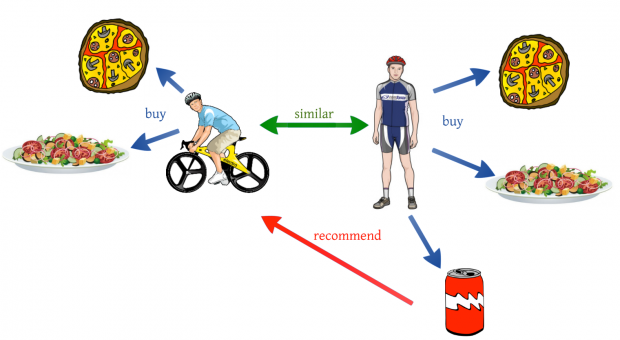

Как посчитать похожесть пользователей?

* Косинусная мера - косинус угла между векторами рейтингов. Если два вектора равнонаправлены, их косинусный коэффициент равен 1. Если направление противоположно, то -1.

$$ \text{similarity}=\cos(\theta )={\mathbf {A} \cdot \mathbf {B}  \over \|\mathbf {A} \|_{2}\|\mathbf {B} \|_{2}}={\frac {\sum \limits _{i=1}^{n}{A_{i}B_{i}}}{{\sqrt {\sum \limits _{i=1}^{n}{A_{i}^{2}}}}{\sqrt {\sum \limits _{i=1}^{n}{B_{i}^{2}}}}}} $$

В нашем случае присутствуют все "оценки" - пользователь интересуется темой (1) или не интересуется (0).  
В случае отсуствия оценок - брать пересечение предметов пользователей

* Коэффициент Пирсона

Пусть даны две выборки $x^m=\left( x_1, \cdots ,x_m  \right)$,  $y^m=\left( y_1, \cdots ,y_m  \right)$

$$r_{xy} = \frac {\sum_{i=1}^{m} \left( x_i-\bar{x} \right)\left( y_i-\bar{y} \right)}{\sqrt{\sum_{i=1}^{m} \left( x_i-\bar{x} \right)^2 \sum_{i=1}^{m} \left( y_i-\bar{y} \right)^2}} = \frac {cov(x,y)}{\sqrt{s_x^2 s_y^2}}$$

где $\bar{x}$, $\bar{y}$ – выборочные средние $x^m$ и $y^m$, $s_x^2$,  $s_y^2$ – выборочные дисперсии, $r_{xy} \in \left[-1,1\right]$.


In [5]:
#
# User-Based Collaborative Filtering
#

user_similarities = cosine_similarity(user_interest_matrix, user_interest_matrix)
# схожесть первого пользователя с остальными
user_similarities[0]

array([ 1.        ,  0.3380617 ,  0.        ,  0.        ,  0.        ,
        0.15430335,  0.        ,  0.        ,  0.18898224,  0.56694671,
        0.        ,  0.        ,  0.        ,  0.16903085,  0.        ])

Простейший способ рекомендации - просуммировать коэффициенты схожести пользователей по каждой теме (для нашего случая это подходит, так как оценки 1 или 0 и нам нужно ранжирование.

In [6]:
def most_similar_users_to(user_id):
    user = user_similarities[user_id]
    
    pairs = [(other_user_id, similarity)                      
             for other_user_id, similarity in enumerate(user) 
             if user_id != other_user_id and similarity > 0]  

    return sorted(pairs, key=lambda x: x[1], reverse=True)   


def user_based_suggestions(user_id, include_current_interests=False):
    suggestions = defaultdict(float)
    for other_user_id, similarity in most_similar_users_to(user_id):
        for interest in users_interests[other_user_id]:
            suggestions[interest] += similarity


    suggestions = sorted(suggestions.items(),
                         key=lambda (_, weight): weight,
                         reverse=True)


    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight) 
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]
    
print("User based similarity")
print("most similar to 0")
print(users_interests[0])
print(users_interests[9])
print(most_similar_users_to(0))

print("Suggestions for 0")
print(user_based_suggestions(0))

User based similarity
most similar to 0
['Hadoop', 'Big Data', 'HBase', 'Java', 'Spark', 'Storm', 'Cassandra']
['Hadoop', 'Java', 'MapReduce', 'Big Data']
[(9, 0.56694670951384074), (1, 0.33806170189140661), (8, 0.1889822365046136), (13, 0.1690308509457033), (5, 0.15430334996209191)]
Suggestions for 0
[('MapReduce', 0.56694670951384074), ('MongoDB', 0.50709255283710997), ('Postgres', 0.50709255283710997), ('NoSQL', 0.33806170189140661), ('neural networks', 0.1889822365046136), ('deep learning', 0.1889822365046136), ('artificial intelligence', 0.1889822365046136), ('databases', 0.1690308509457033), ('MySQL', 0.1690308509457033), ('programming languages', 0.15430334996209191), ('Python', 0.15430334996209191), ('Haskell', 0.15430334996209191), ('C++', 0.15430334996209191), ('R', 0.15430334996209191)]


Если нужно предсказать рейтинг (u - пользователь, i - предмет):

$$\hat{r}_{u,i} = \bar{r_i} + \frac{\sum_v s_{u,v} (r_{v, i} -  \bar{r_v})}{\sum_v |s_{u,v}|}$$

#### Замечения:

1. Пользователи часто ставят пессимистичные или оптимистичные оценки, поэтому считаем $\bar{r_u}$ - средняя оценка пользователя, и делаем поправку

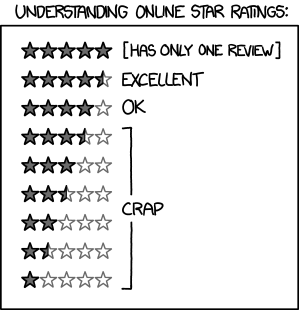

2. Искать подробную информацию можно по "GroupLens algorithm"

3. Можно не суммировать по всем пользователям, а ограничиться ближайшими соседями

4. При росте размерности похожие пользователи перестают на самом деле быть похожими (проклятие размерности) и рекомендация работает плохо

5. Естественно предположить, что продукты, которые любят или не любят практически все пользователи, не слишком полезны в определении ближайшего соседа. Поэтому естественно взвесить продукты по тому, как часто их уже оценивали пользователи; такая метрика называется iuf – inverse user frequency, обратная частота пользователей

## Коллаборативная фильтрация по схожести предметов
Item-Based Collaborative Filtering

Будем считать сходство непосредственно между темами. После этого можно рекомендовать пользователю темы, похожие на те, которые его уже интересуют.

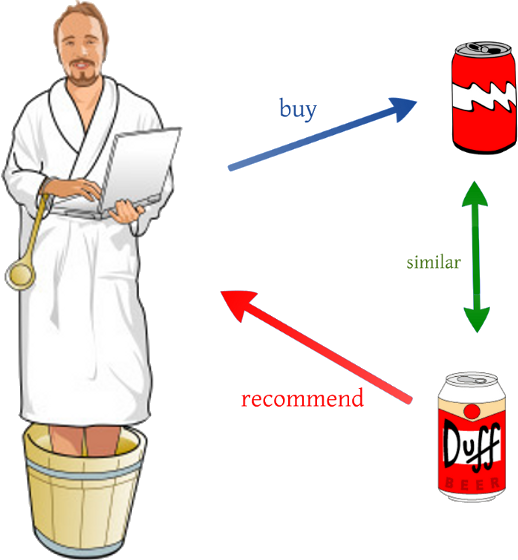

In [7]:
interest_user_matrix = user_interest_matrix.T

interest_similarities = cosine_similarity(interest_user_matrix, interest_user_matrix)
interest_similarities[0]

array([ 1.        ,  0.        ,  0.40824829,  0.33333333,  0.81649658,
        0.        ,  0.66666667,  0.        ,  0.57735027,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.57735027,  0.57735027,  0.40824829,  0.        ,  0.        ,
        0.40824829,  0.        ,  0.        ,  0.        ,  0.40824829,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [26]:
def most_similar_interests_to(interest_id):
    similarities = interest_similarities[interest_id]
    pairs = [(unique_interests[other_interest_id], similarity)
             for other_interest_id, similarity in enumerate(similarities)
             if interest_id != other_interest_id and similarity > 0]
    return sorted(pairs,
                  key=lambda (_, similarity): similarity,
                  reverse=True)

def item_based_suggestions(user_id, include_current_interests=False):
    suggestions = defaultdict(float)
    user_interest_vector = user_interest_matrix[user_id]
    for interest_id, is_interested in enumerate(user_interest_vector):
        if is_interested == 1:
            similar_interests = most_similar_interests_to(interest_id)
            for interest, similarity in similar_interests:
                suggestions[interest] += similarity

    suggestions = sorted(suggestions.items(),
                         key=lambda (_, similarity): similarity,
                         reverse=True)

    if include_current_interests:
        return suggestions
    else:
        return [(suggestion, weight) 
                for suggestion, weight in suggestions
                if suggestion not in users_interests[user_id]]


print("Item based similarity")
print("most similar to 'Big Data'")
print(most_similar_interests_to(0))

print("suggestions for user 0")
print(item_based_suggestions(0))

Item based similarity
most similar to 'Big Data'
[('Hadoop', 0.81649658092772603), ('Java', 0.66666666666666685), ('MapReduce', 0.57735026918962584), ('Spark', 0.57735026918962584), ('Storm', 0.57735026918962584), ('Cassandra', 0.40824829046386302), ('artificial intelligence', 0.40824829046386302), ('deep learning', 0.40824829046386302), ('neural networks', 0.40824829046386302), ('HBase', 0.33333333333333343)]
suggestions for user 0
[('MapReduce', 1.8618073195657989), ('Postgres', 1.3164965809277258), ('MongoDB', 1.3164965809277258), ('NoSQL', 1.2844570503761732), ('programming languages', 0.57735026918962584), ('MySQL', 0.57735026918962584), ('Haskell', 0.57735026918962584), ('databases', 0.57735026918962584), ('neural networks', 0.40824829046386302), ('deep learning', 0.40824829046386302), ('C++', 0.40824829046386302), ('artificial intelligence', 0.40824829046386302), ('Python', 0.28867513459481292), ('R', 0.28867513459481292)]


#### Замечания
* Можно считать оффлайн, так как предметы появляются редко, оценка нескольких пользователей не влияет сильно на предмет
* Для новых предметов нужно каким-либо образом получить несколько оценок
* Эффект пузыря - никогда не получим рекомендацию новой, не известной нам ранее темы

#### Общие замечания
* Вычисления ресурсоемкие - все оценки нужно хранить в памяти
* Иногда пользователь кликнул, но ему не понравилось (!)

# https://grouplens.org/datasets/movielens/100k/

In [8]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import Reader, Dataset, SVD, evaluate

In [28]:
data = Dataset.load_builtin('ml-100k')

algo = SVD()

cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /home/stroykova/.surprise_data/ml-100k
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
MAE (testset)     0.7304  0.7461  0.7362  0.7379  0.7322  0.7366  0.0055  
RMSE (testset)    0.9278  0.9448  0.9361  0.9357  0.9290  0.9347  0.0061  
Fit time          6.99    7.10    7.73    7.01    6.30    7.02    0.46    
Test time         0.31    0.28    0.27    0.24    0.23    0.27    0.03    


{u'fit_time': (6.990236043930054,
  7.097143888473511,
  7.733065128326416,
  7.0077831745147705,
  6.296708106994629),
 u'test_mae': array([ 0.73043216,  0.74611877,  0.73617721,  0.73791609,  0.73221275]),
 u'test_rmse': array([ 0.92779505,  0.94483671,  0.93612361,  0.93571246,  0.92901848]),
 u'test_time': (0.3109879493713379,
  0.2827150821685791,
  0.27110815048217773,
  0.2404930591583252,
  0.23340106010437012)}

In [34]:
svd = SVD()
evaluate(svd, data, measures=['RMSE', 'MAE'])

/usr/local/lib/python2.7/dist-packages/surprise/evaluate.py:66: UserWarning: The evaluate() method is deprecated. Please use model_selection.cross_validate() instead.
  'model_selection.cross_validate() instead.', UserWarning)
/usr/local/lib/python2.7/dist-packages/surprise/dataset.py:193: UserWarning: Using data.split() or using load_from_folds() without using a CV iterator is now deprecated. 
  UserWarning)


Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9285
MAE:  0.7309
------------
Fold 2
RMSE: 0.9409
MAE:  0.7423
------------
Fold 3
RMSE: 0.9349
MAE:  0.7366
------------
Fold 4
RMSE: 0.9413
MAE:  0.7447
------------
Fold 5
RMSE: 0.9360
MAE:  0.7377
------------
------------
Mean RMSE: 0.9363
Mean MAE : 0.7384
------------
------------


CaseInsensitiveDefaultDict(list,
                           {'mae': [0.7308917660143458,
                             0.74228424729822073,
                             0.73663267892470907,
                             0.74465972589118024,
                             0.73768849798557401],
                            'rmse': [0.928460416944629,
                             0.94094038512330092,
                             0.93486015017427293,
                             0.94131964671108259,
                             0.93599602730940312]})

In [35]:
trainset = data.build_full_trainset()
svd.train(trainset)

/usr/local/lib/python2.7/dist-packages/surprise/prediction_algorithms/algo_base.py:51: UserWarning: train() is deprecated. Use fit() instead
  warnings.warn('train() is deprecated. Use fit() instead', UserWarning)


In [37]:
svd.predict(1, 302, 5)

Prediction(uid=1, iid=302, r_ui=None, est=3.5298600000000002, details={u'was_impossible': False})

# SVD

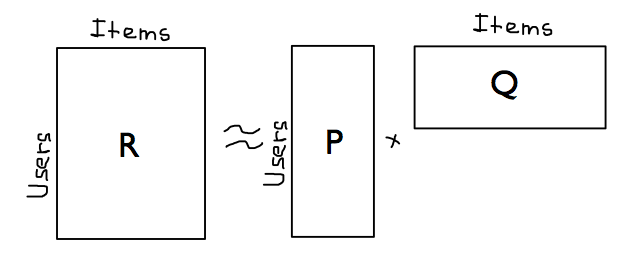

Для любого пользователя можно предсказать оценки, которые он еще не ставил. Обучать модель нужно так, чтобы она давала наименьшие ошибки для уже известных моделей.

Предсказание - скалярное произведение вектора для пользователя и вектора для объекта.

При таком подходе необходимо обучить намного меньше параметров модели

SVD напрямую применить нельзя, так как очень много отсутствующих значений (точнее можно, как-то заполнив их, но получается не очень хорошее качество).  
Поэтому формулируется задача оптимизации по известным оценкам $K$:

$$ min_{p, q} \sum_{u,i \in K} (r_{ui} - q_i^T p_u)^2 + \lambda (||q_i||^2 + ||p_u||^2)$$

# Оценка качества

* Качество рейтингов
    * MAE, MSE
* Качество событий
    * F-score, ROC-AUC, PR-AUC
    * precision@k, recall@k
* Качество ранжирования
    * $\mathrm{DCG}_{\mathrm{p}}=\sum_{i=1}^{p} \frac{r e l_{i}}{\log _{2}(i+1)}=r e l_{1}+\sum_{i=2}^{p} \frac{r e l_{i}}{\log _{2}(i+1)}$
    * $\mathrm{DCG}_{\mathrm{p}}=\sum_{i=1}^{p} \frac{2^{r e l_{i}}-1}{\log _{2}(i+1)}$
    * nDCG -- нормализованный DCG
   

1. https://habrahabr.ru/company/surfingbird/blog/139518/
2. https://d4datascience.wordpress.com/category/predictive-analytics/
3. Data Science from scratch книга
4. https://habrahabr.ru/company/yandex/blog/241455/
5. https://www.kaggle.com/rounakbanik/movie-recommender-systems/notebook
6. http://www.cs.ubbcluj.ro/~gabis/DocDiplome/SistemeDeRecomandare/Recommender_systems_handbook.pdf
7. https://www.coursera.org/specializations/recommender-systems
8. https://www.cs.umd.edu/~samir/498/Amazon-Recommendations.pdf
9. https://datajobs.com/data-science-repo/Recommender-Systems-[Netflix].pdf
10. http://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD